In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyfinlab import data_api as api
from pyfinlab import risk_models as risk
from pyfinlab import return_models as ret
from portfoliolab.modern_portfolio_theory import MeanVarianceOptimisation
from pypfopt import EfficientFrontier

In [2]:
classification_schema = pd.read_csv('../data/classification_schema.csv')

In [3]:
tickers = list(classification_schema.TICKER)

In [4]:
start_date = (datetime.today() - timedelta(days=365*5)).strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')

In [5]:
prices = api.price_history(tickers, start_date, end_date)

[*********************100%***********************]  18 of 18 completed


In [6]:
rf = 0.013 # risk-free rate to be used

## Select Risk Model

Comment in and run to see available risk models

In [28]:
# risk.risk_models[:16] # PortfolioLab risk models
risk.risk_models[16:] # PyPortfolioOpt risk models

['sample_cov',
 'semicovariance',
 'exp_cov',
 'ledoit_wolf_constant_variance',
 'ledoit_wolf_single_factor',
 'ledoit_wolf_constant_correlation',
 'oracle_approximating']

In [29]:
risk_model = 'sample_cov'
S = risk.risk_model(prices, risk_model) * 252

## Select Return Model

Comment in and run to see available return models

In [40]:
# ret.return_models[:3] # PortfolioLab return models
ret.return_models[3:] # PyPortfolioOpt return models

['avg_historical_return', 'ema_historical_return', 'capm_return']

In [30]:
return_model = 'mean_historical_return'
mu = ret.return_model(prices, return_model, rf=rf)

## Instantiate Class

In [31]:
mvo = MeanVarianceOptimisation(risk_free_rate=rf)

## Efficent Frontier

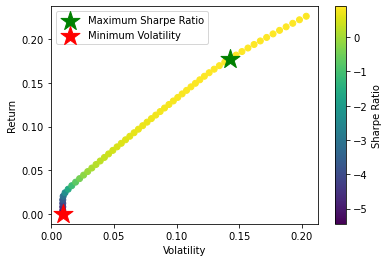

In [32]:
expected_returns = mu
covariance = S
plot = mvo.plot_efficient_frontier(S, max_return=0.4, expected_asset_returns=mu)

## Mean-Variance Portfolio Optimization with PortfolioLab

In [33]:
mvo.allocate(
    asset_names=prices.columns,
    expected_asset_returns=mu,
    covariance_matrix=S,
    solution='max_sharpe'
)
weights = mvo.weights.iloc[0].sort_values(ascending=False).round(6).to_frame()
weights.columns = ['Portfolio']
weights = weights[weights['Portfolio']!=0]
print('Total Weights: {}%'.format(weights.sum().squeeze()*100))
weights

Total Weights: 100.0%


,Portfolio
SHY,0.958214
IWF,0.037114
ANGL,0.004672


In [37]:
mvo.get_portfolio_metrics()

Portfolio Return = 0.023314833195638197
Portfolio Risk = 0.20577830230794295
Portfolio Sharpe Ratio = 0.022738531795486277


## Mean-Variance Portfolio Optimization with PyPortfolioOpt

In [34]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=rf)
weights = ef.clean_weights(0.005)
weights = pd.DataFrame.from_dict(
    weights, orient='index', columns=['Portfolio']).round(4).sort_values(by='Portfolio', ascending=False).round(6)
weights = weights[weights['Portfolio']!=0]
print('Total Weights: {}%'.format(weights.sum().squeeze()*100))
weights

Total Weights: 99.99999999999999%


,Portfolio
SHY,0.5134
GOVT,0.3188
IWF,0.1616
ANGL,0.0062


In [39]:
ef.portfolio_performance(verbose=True, risk_free_rate=rf)

Expected annual return: 5.2%
Annual volatility: 3.2%
Sharpe Ratio: 1.22


(0.05249259282190721, 0.03236601972172079, 1.220186886168267)